In [62]:
import pandas as pd
import PIL
import torch
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import models
from torch import optim
import torch.nn as nn
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [63]:
#Загружаем данные
data = pd.read_csv('train.csv')

In [64]:
#Надо выборку то поделить на трейн и тест
data_train, data_val = train_test_split(data,train_size=0.6,shuffle = True)

In [65]:
data_test = pd.read_csv('test.csv')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
trans = transforms.ToTensor()

In [66]:
#Глянем на реализацию простой модели 
#первый слой 1 канал в 64 канала
#model = models.vgg19(pretrained=False)
#next(data_train.iterrows())[10]
#data_train.iloc[0,:][1:]

In [68]:
#clf = Classif().to(device)
#optimizer = optim.AdamW(clf.parameters(), lr=0.0001) 0.4
clf = models.resnet101(pretrained=True)
clf.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
clf.fc = nn.Linear(in_features=2048, out_features=10, bias=True)
clf = clf.to(device)
#Заморозим параметры
for ind, layer in enumerate(clf.children()):
  if (ind == 5): break
  layer.requires_grad_ = False 


optimizer = optim.Adamax(clf.parameters())
lossF = nn.CrossEntropyLoss()


In [69]:
def batch_generator(data, batch_size=10):
  df = data.reset_index().iloc[:,1:]
  for ind in range(1,data.shape[0]+1): # ПОСЛЕДНЕЕ ИЗМЕНЕНИЕ +1 НЕ ПРОВЕРЕННО
    if (ind%batch_size) == 0: # получаем батч
      df = data.iloc[(ind-batch_size):ind,1:]
      x_batch = torch.from_numpy(np.array(df).reshape(df.shape[0],28,-1)[:,np.newaxis]).type(torch.FloatTensor) # batchx 1 x 28 x 28
      y_batch = torch.from_numpy(np.array(data.iloc[(ind-batch_size):ind,0])).to(device)    
      yield x_batch, y_batch
def batch_test_generator(data, batch_size=10):
  df = data.reset_index().iloc[:,1:]
  for ind in range(1,data.shape[0]+1):
    if (ind%batch_size) == 0: # получаем батч
      df = data.iloc[(ind-batch_size):ind,:]
      x_batch = torch.from_numpy(np.array(df).reshape(df.shape[0],28,-1)[:,np.newaxis]).type(torch.FloatTensor) # batchx 1 x 28 x 28
      #y_batch = torch.from_numpy(np.array(data.iloc[(ind-batch_size):ind,0])).to(device)    
      yield x_batch

In [70]:
#Обучающий цикл 
losses = []
losses_val = []
acc=[]
acc_val = []
batch_size = 1000

best_params = clf.parameters
x_batch,y_batch = next(batch_generator(data_train, batch_size = batch_size))
x_batch = x_batch.to(device)
y_true = y_batch.to(device)
#Forward propogation
y_pred = clf(x_batch)
min_loss = lossF(y_pred,y_true)

epoches = 20
for ep in range(1,epoches+1):
    loss_ep=0
    clf.train()
    for x_batch,y_batch in batch_generator(data_train, batch_size = batch_size):
      optimizer.zero_grad()

      #Перенесем на GPU
      x_batch = x_batch.to(device)
      y_true = y_batch.to(device)
      #Forward propogation
      y_pred = clf(x_batch)
      loss = lossF(y_pred,y_true)


      #Пробуем достать параметры модели при которых наилучшее качество 
      #if (min_loss > loss): 
        #best_params = clf.parameters
        #min_loss = loss

      loss.backward()
      optimizer.step()

      loss_ep = loss_ep+loss.item()

    losses.append(loss_ep/(data_train.shape[0]//batch_size))

    clf.eval()
    #train metric
    x_batch,y_batch=next(batch_generator(data_train, batch_size = batch_size))
    x_batch = x_batch.to(device)
    y_true = y_batch.to(device)

    y_pred = clf(x_batch)
    metr = sum(y_pred.argmax(1)==y_true)/batch_size
    acc.append(metr)

    #val metric
    x_batch,y_batch=next(batch_generator(data_val, batch_size = batch_size))
    x_batch = x_batch.to(device)
    y_true = y_batch.to(device)

    y_pred = clf(x_batch)
    metr = sum(y_pred.argmax(1)==y_true)/batch_size
    acc_val.append(metr)

    loss_val = lossF(y_pred,y_true)
    losses_val.append(loss_val.item())
  
    print('epoch {0} is done, val_loss is: {1}'.format(ep,loss_val))
print('Max Val Accuracy: {}'.format(max(acc_val)))


epoch 1 is done, val_loss is: 0.21008454263210297
epoch 2 is done, val_loss is: 0.10380184650421143
epoch 3 is done, val_loss is: 0.07335418462753296
epoch 4 is done, val_loss is: 0.06407938152551651
epoch 5 is done, val_loss is: 0.08566807210445404
epoch 6 is done, val_loss is: 0.09721829742193222
epoch 7 is done, val_loss is: 0.09322164952754974
epoch 8 is done, val_loss is: 0.11519049108028412
epoch 9 is done, val_loss is: 0.10782540589570999
epoch 10 is done, val_loss is: 0.09061775356531143
epoch 11 is done, val_loss is: 0.14227643609046936
epoch 12 is done, val_loss is: 0.0833917185664177
epoch 13 is done, val_loss is: 0.10027791559696198
epoch 14 is done, val_loss is: 0.09536071866750717
epoch 15 is done, val_loss is: 0.09113440662622452
epoch 16 is done, val_loss is: 0.08256036043167114
epoch 17 is done, val_loss is: 0.08699710667133331
epoch 18 is done, val_loss is: 0.08847029507160187
epoch 19 is done, val_loss is: 0.08992138504981995
epoch 20 is done, val_loss is: 0.09113793

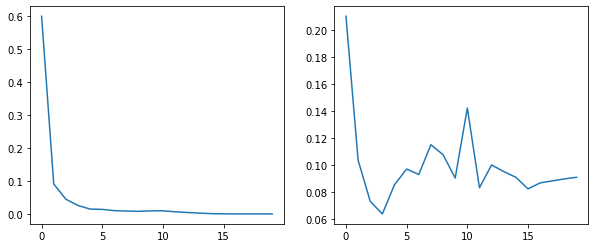

In [71]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2,1)
ax.plot(list(range(len(losses))), losses)
ax1 = fig.add_subplot(1,2,2)
ax1.plot(list(range(len(losses_val))), losses_val)

[Text(0.5, 1.0, 'Accuracy Val')]

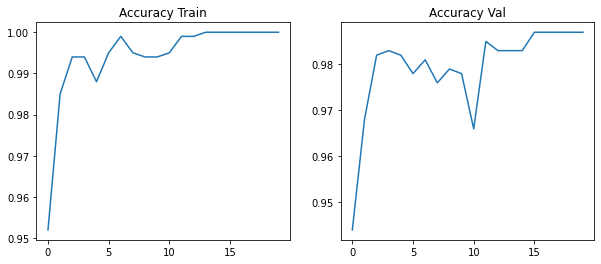

In [72]:
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(list(range(len(acc))), acc)
ax2 = fig.add_subplot(1,2,2)
ax2.plot(list(range(len(acc_val))), acc_val)
ax1.set(title = 'Accuracy Train')
ax2.set(title = 'Accuracy Val')

In [ ]:
#Сохранение модели
'''
from google.colab import drive
drive.mount('/content/gdrive')
path = f'gdrive/MyDrive/model.pth'
torch.save(clf,path)
'''

In [ ]:
#Загрузка модели(Гугл присоеденен)
'''
path = f'gdrive/MyDrive/model.pth'
torch.cuda.empty_cache()
clf = torch.load(path).to('cpu')
'''

In [73]:
#Проверка модели на тесте
#Будем батчами предикт получать
y=torch.tensor([]).to(device)
pre_test = torch.from_numpy(np.array(data_test).reshape(data_test.shape[0],28,-1)[:,np.newaxis]).type(torch.FloatTensor) # 28.. x 1 x 28 x 28
for x_batch in batch_test_generator(data_test, batch_size = batch_size):
    x_batch = x_batch.to(device)
    y_pred = clf(x_batch).argmax(1)
    y = torch.cat((y,y_pred))
y = y.to('cpu')

In [74]:
ans = pd.read_csv('sample_submission.csv')

In [75]:
ans['Label'] = y.long()

In [76]:
ans

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [77]:
#Сохраняем ответ
ans.to_csv('/content/gdrive/MyDrive/RecognizeSymb/file2.csv', index=False)

In [58]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive
